In [18]:
import tensorflow as tf
import numpy as np

In [19]:
corpus_raw = "He is the king . The king is royal . She is the royal queen"

In [20]:
raw_sentence = corpus_raw.split(".")
sentences = []
for sentence in raw_sentence:
    sentences.append(sentence.strip().split())
    
sentences

[['He', 'is', 'the', 'king'],
 ['The', 'king', 'is', 'royal'],
 ['She', 'is', 'the', 'royal', 'queen']]

In [21]:
data = []
WINDOW_SIZE = 2

for sentence in sentences:
    for word_index, word in enumerate(sentence):
        start_index = max(word_index - WINDOW_SIZE, 0)
        end_index = min(word_index + WINDOW_SIZE + 1, len(sentence))
        
        for nb_word in sentence[start_index : word_index]:
            data.append([word, nb_word])
            
        for nb_word in sentence[word_index+1 : end_index]:
            data.append([word, nb_word])
            
data

[['He', 'is'],
 ['He', 'the'],
 ['is', 'He'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'He'],
 ['the', 'is'],
 ['the', 'king'],
 ['king', 'is'],
 ['king', 'the'],
 ['The', 'king'],
 ['The', 'is'],
 ['king', 'The'],
 ['king', 'is'],
 ['king', 'royal'],
 ['is', 'The'],
 ['is', 'king'],
 ['is', 'royal'],
 ['royal', 'king'],
 ['royal', 'is'],
 ['She', 'is'],
 ['She', 'the'],
 ['is', 'She'],
 ['is', 'the'],
 ['is', 'royal'],
 ['the', 'She'],
 ['the', 'is'],
 ['the', 'royal'],
 ['the', 'queen'],
 ['royal', 'is'],
 ['royal', 'the'],
 ['royal', 'queen'],
 ['queen', 'the'],
 ['queen', 'royal']]

In [22]:
words = []
for word in corpus_raw.split():
    if word != '.':
        words.append(word)
words = set(words)

word2int = {}
int2word = {}
vocab_size = len(words)

for i, word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
    
print(word2int)
print(int2word)

{'the': 0, 'She': 1, 'royal': 2, 'is': 3, 'queen': 4, 'The': 5, 'king': 6, 'He': 7}
{0: 'the', 1: 'She', 2: 'royal', 3: 'is', 4: 'queen', 5: 'The', 6: 'king', 7: 'He'}


In [23]:
def to_one_hot(word_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[word_index] = 1
    return temp

In [26]:
x_train = []
y_train = []
for word in data:
    x_train.append(to_one_hot(word2int[word[0]], vocab_size))
    y_train.append(to_one_hot(word2int[word[1]], vocab_size))

In [27]:
x_train[:3]

[array([0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 1., 0., 0., 0., 0.])]

In [28]:
y_train[:3]

[array([0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1.])]

In [29]:
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

x_train

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 

In [30]:
class Word2Vec:
    def __init__(self, vocab_size=10, embedding_dim=5, optimizer='sgd', epochs=1000, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        if optimizer == 'adam':
            self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        else:
            self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
        self.epochs = epochs

        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim]))

        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))

    def vectorized(self, word_index):
        return (self.W1 + self.b1)[word_index]


    def train(self, x_train, y_train):
        for i in range(self.epochs):
            with tf.GradientTape() as tape:
                hidden_layer = tf.add(tf.matmul(x_train, self.W1), self.b1)
                output_layer = tf.add(tf.matmul(hidden_layer, self.W2), self.b2)

                pred = tf.nn.softmax(output_layer)
                loss = tf.reduce_mean(-tf.math.reduce_sum(y_train*tf.math.log(pred), axis=[1]))

                grads = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2])
                self.optimizer.apply_gradients(zip(grads, [self.W1, self.b1, self.W2, self.b2]))

            if i % 1000 == 0:
                print(loss)

In [31]:
w2v = Word2Vec(vocab_size=vocab_size, embedding_dim=5, optimizer='SGD', epochs=10000, learning_rate=0.1)
w2v.train(x_train, y_train)

tf.Tensor(6.1898546, shape=(), dtype=float32)
tf.Tensor(1.3889955, shape=(), dtype=float32)
tf.Tensor(1.3795668, shape=(), dtype=float32)
tf.Tensor(1.3772283, shape=(), dtype=float32)
tf.Tensor(1.3762264, shape=(), dtype=float32)
tf.Tensor(1.3756828, shape=(), dtype=float32)
tf.Tensor(1.3753462, shape=(), dtype=float32)
tf.Tensor(1.375119, shape=(), dtype=float32)
tf.Tensor(1.3749561, shape=(), dtype=float32)
tf.Tensor(1.3748343, shape=(), dtype=float32)


In [32]:
w2v.vectorized(word2int['queen']).numpy()

array([-2.6513228 , -2.119599  , -1.4017407 ,  1.6131532 , -0.99202585],
      dtype=float32)

In [33]:
w2v.vectorized(word2int['king']).numpy()

array([-0.04989499, -1.8294151 , -1.1168658 ,  1.8642952 ,  2.4349895 ],
      dtype=float32)

In [34]:
vector = w2v.W1 + w2v.b1
vector.shape

TensorShape([8, 5])

In [35]:

from sklearn.manifold import TSNE
from sklearn import preprocessing

model = TSNE(n_components=2, random_state=42)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vector)

normalizer = preprocessing.Normalizer()
vectors = normalizer.fit_transform(vectors,'l2')

He [0.45033774 0.89285827]
is [-0.24413551  0.9697411 ]


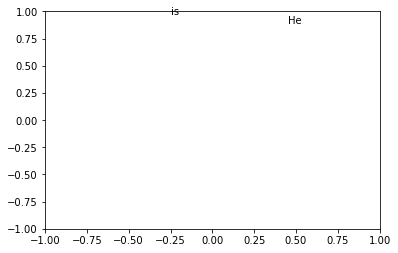

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom =-1, top=1)
for word in words:
    print(word, vectors[word2int[word]])
    ax.annotate(word, (vectors[word2int[word]][0], vectors[word2int[word]][1]))

plt.show()

In [37]:
import pandas as pd